## Sentiment Anylisis Model Gift Cards
### COMP262 - Group 5


### 1. Dataset data exploration

In [36]:
import numpy as np
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from textblob import TextBlob
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
%matplotlib inline
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected = True)
cf.go_offline()
import plotly.graph_objs as go
from plotly.subplots import make_subplots


ModuleNotFoundError: No module named 'textblob'

In [37]:
import json
import pandas as pd
df = pd.read_json(r'Gift_Cards_5.json',lines = True)

overall - rating of the product (0 to 5) 
verified  - true or false
reviewTime - time of the review (raw)
reviewerID - ID of the reviewer, e.g. A31UBHTUUIFJUT
asin - ID of the product, e.g. B004LLIKVU
style - a disctionary of the product metadata, e.g., "Format" is "Hardcover"
reviewerName - name of the reviewer
reviewText - text of the review
summary - summary of the review
unixReviewTime - time of the review (unix time)
vote - helpful votes of the review
image - images that users post after they have received the product

overall (bigint) – User rating (1-5)
verified (boolean)  Is the review verified (true, false)
reviewtime (string) – Timestamp formatted like “10 30, 2009”
reviewerid (string) – Amazon generated user id
asin (string) – Unique Amazon generated product id
reviewername (string) – User supplied name
reviewtext (string) – Review text
summary (string) – Summary of Review text
unixreviewtime (bigint) – Timestamp formatted in epoch time.
vote (double) – Userful voters form other users

In [38]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2972 entries, 0 to 2971
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         2972 non-null   int64  
 1   verified        2972 non-null   bool   
 2   reviewTime      2972 non-null   object 
 3   reviewerID      2972 non-null   object 
 4   asin            2972 non-null   object 
 5   style           864 non-null    object 
 6   reviewerName    2972 non-null   object 
 7   reviewText      2966 non-null   object 
 8   summary         2972 non-null   object 
 9   unixReviewTime  2972 non-null   int64  
 10  vote            208 non-null    float64
 11  image           12 non-null     object 
dtypes: bool(1), float64(1), int64(2), object(8)
memory usage: 258.4+ KB


In [39]:
df.describe()

,overall,unixReviewTime,vote
count,2972.000000,2.972000e+03,208.000000
mean,4.885262,1.476136e+09,5.158654
std,0.484660,3.379616e+07,7.366121
min,1.000000,1.327968e+09,2.000000
25%,5.000000,1.454890e+09,2.000000
50%,5.000000,1.482710e+09,3.000000
75%,5.000000,1.500271e+09,5.000000
max,5.000000,1.534896e+09,60.000000


In [40]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5,True,"06 17, 2018",A31UBHTUUIFJUT,B004LLIKVU,{'Gift Amount:': ' 50'},john stoiber,Another great gift.,Five Stars,1529193600,NaN,NaN
1,4,True,"06 14, 2018",A2MN5JQMIY0FQ2,B004LLIKVU,{'Gift Amount:': ' 50'},Amazon Customer,Gift card for my daughter,Ease of use,1528934400,NaN,NaN
2,5,True,"06 2, 2018",A25POI5IGGENPM,B004LLIKVU,{'Gift Amount:': ' 50'},Kindle Customer,Nice present,Five Stars,1527897600,NaN,NaN
3,5,True,"05 19, 2018",A2HYGTHB4LJ9FW,B004LLIKVU,{'Gift Amount:': ' 50'},Amante dei Gatti,My niece loved this birthday greeting/gift card.,Love the convenience of eCards,1526688000,NaN,NaN
4,5,True,"05 18, 2018",ACDG3M94UMZGJ,B004LLIKVU,{'Gift Amount:': ' 50'},Joan Freesh,fine as a gift.,Five Stars,1526601600,NaN,NaN


## 1a. Counts, averages, missing values

In [41]:
# Column counts
df.count()

overall           2972
verified          2972
reviewTime        2972
reviewerID        2972
asin              2972
style              864
reviewerName      2972
reviewText        2966
summary           2972
unixReviewTime    2972
vote               208
image               12
dtype: int64

In [42]:
# Frequency for overall ratings
df.overall.value_counts()

overall
5    2752
4     154
3      33
1      22
2      11
Name: count, dtype: int64

In [43]:
df['overall'].mean()

4.885262449528937

In [63]:
def missing_values_analysis(df):
    na_columns = [col for col in df.columns if df[col].isnull().sum() > 0]  # Columns with missing values
    n_miss = df[na_columns].isnull().sum().sort_values(ascending=False)  # Number of missing values, sorted
    ratio = (df[na_columns].isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)  # Percentage of missing values, sorted
    missing_df = pd.concat([n_miss, np.around(ratio, 2)], axis=1, keys=['Missing Values', 'Ratio (%)'])  # Concatenate counts and percentages
    return missing_df
def check_dataframe(df, head=5, tail=5):
    print("SHAPE".center(82, '~'))
    print('Rows: {}'.format(df.shape[0]))
    print('Columns: {}'.format(df.shape[1]))
    print("TYPES".center(82,'~'))
    print(df.dtypes)
    print("MISSING VALUES ANALYSIS".center(82, '~'))
    print(missing_values_analysis(df))
    print("FREQUENCY ANALYSIS".center(82, '~'))
    print(f"Frequency for {'overall'}:".center(82, '-'))
    print(df['overall'].value_counts().head())  
    print("\n")
    print("QUANTILES".center(82, '~'))
    try:
        # Calculate quantiles for numeric columns only
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        print(df[numeric_cols].quantile([0, 0.50, 0.75, 1]).T)
    except Exception as e:
        print(f"Error calculating quantiles: {e}")
    if head > 0:
        print("FIRST {} ROWS".format(head).center(82, '~'))
        print(df.head(head))
    if tail > 0:
        print("LAST {} ROWS".format(tail).center(82, '~'))
        print(df.tail(tail))

# You can now call check_dataframe(df) again with this adjusted function.
check_dataframe(df)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~SHAPE~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Rows: 2972
Columns: 12
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~TYPES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
overall             int64
verified             bool
reviewTime         object
reviewerID         object
asin               object
style              object
reviewerName       object
reviewText         object
summary            object
unixReviewTime      int64
vote              float64
image              object
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~MISSING VALUES ANALYSIS~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            Missing Values  Ratio (%)
image                 2960      99.60
vote                  2764      93.00
style                 2108      70.93
reviewText               6       0.20
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~FREQUENCY ANALYSIS~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------------------------------Frequency for overall:------------------------------
overall
5    2752
4     154
3      33
1      2

In [56]:
def check_dataframe(df, head=5, tail=5):
    print("SHAPE".center(82, '~'))
    print('Rows: {}'.format(df.shape[0]))
    print('Columns: {}'.format(df.shape[1]))
    print("TYPES".center(82,'~'))
    print(df.dtypes)
    print("MISSING VALUES ANALYSIS".center(82, '~'))
    print(missing_values_analysis(df))
    print("QUANTILES".center(82, '~'))
    try:
        # Calculate quantiles for numeric columns only
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        print(df[numeric_cols].quantile([0, 0.50, 0.75, 1]).T)
    except Exception as e:
        print(f"Error calculating quantiles: {e}")
    if head > 0:
        print("FIRST {} ROWS".format(head).center(82, '~'))
        print(df.head(head))
    if tail > 0:
        print("LAST {} ROWS".format(tail).center(82, '~'))
        print(df.tail(tail))

# You can now call check_dataframe(df) again with this adjusted function.
check_dataframe(df)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~SHAPE~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Rows: 2972
Columns: 12
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~TYPES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
overall             int64
verified             bool
reviewTime         object
reviewerID         object
asin               object
style              object
reviewerName       object
reviewText         object
summary            object
unixReviewTime      int64
vote              float64
image              object
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~MISSING VALUES ANALYSIS~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            Missing Values  Ratio (%)
image                 2960      99.60
vote                  2764      93.00
style                 2108      70.93
reviewText               6       0.20
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~QUANTILES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                        0.00          0.50          0.75          1.00
overall         1.000000e+00  5.000000e+00  5.000000e+00  

In [34]:
# classes by variable

import pandas as pd

def check_class(dataframe):
    unique_counts = []
    for column in dataframe.columns:
        try:
            # Attempt to count unique values in the usual way
            unique_count = dataframe[column].nunique()
        except TypeError:
            # Handle unhashable items by converting them to strings (or another approach as needed)
            unique_count = dataframe[column].astype(str).nunique()
        unique_counts.append(unique_count)
    
    # Create DataFrame with counts
    nunique_df = pd.DataFrame({'Variable': dataframe.columns, 'Classes': unique_counts})
    nunique_df = nunique_df.sort_values('Classes', ascending=False).reset_index(drop=True)
    return nunique_df
check_class(df)

,Variable,Classes
0,reviewText,1937
1,summary,952
2,reviewTime,797
3,unixReviewTime,797
4,reviewerID,458
5,reviewerName,429
6,asin,148
7,vote,20
8,style,18
9,image,13


## 1b. Distribution of number of reviews across products

/Users/josemuniz/opt/anaconda3/envs/PX39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/josemuniz/opt/anaconda3/envs/PX39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/josemuniz/opt/anaconda3/envs/PX39/lib/python3.9/site-packages/seaborn/_stats/counting.py:137: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  bin_edges = np.histogram_bin_edges(vals, bins, binrange, weight)
/Users/josemuniz/opt/anaconda3/envs/PX39/lib/python3.9/site-packages/seaborn/_stats/counting.py:176: RuntimeWarning: Converting input from bool to <class 'numpy.

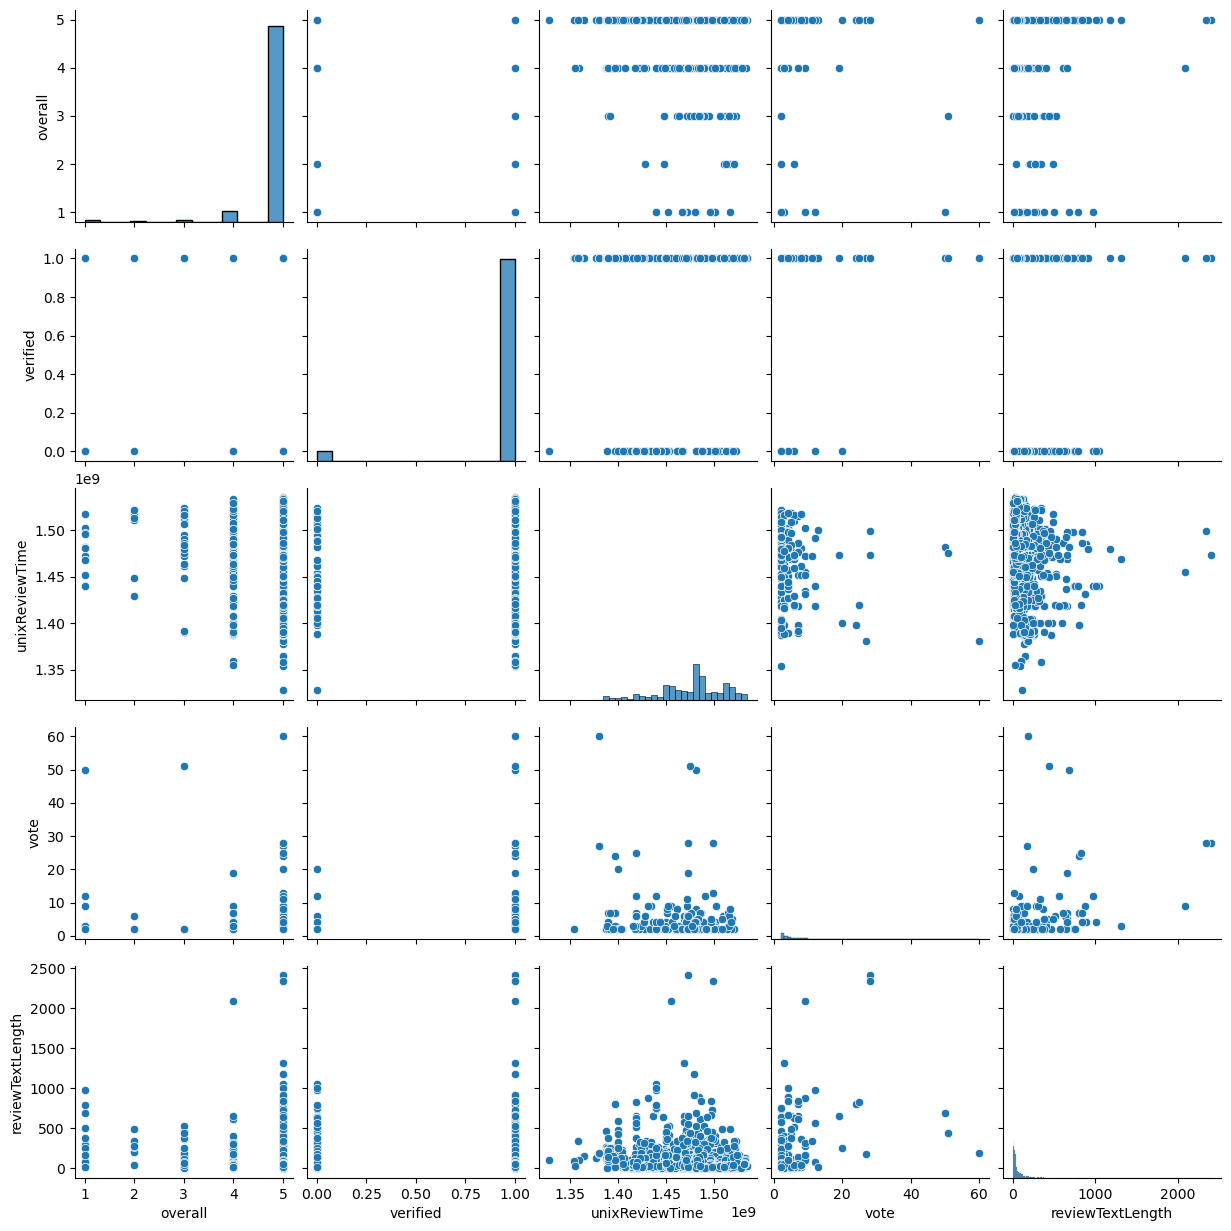

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df)

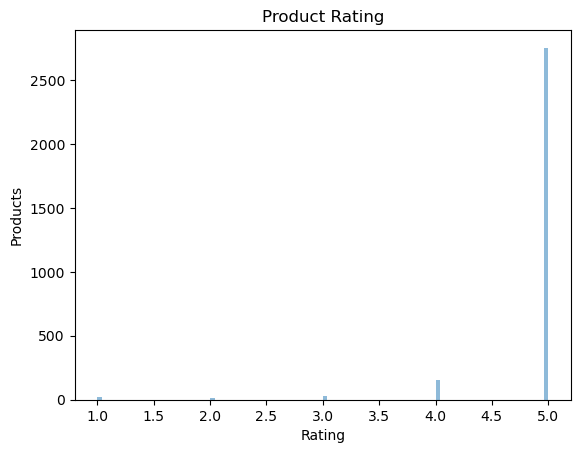

In [15]:
num_bin=100
plt.hist(df['overall'],num_bin,alpha=0.5)
plt.title('Product Rating')
plt.xlabel("Rating")
plt.ylabel("Products")
plt.show()

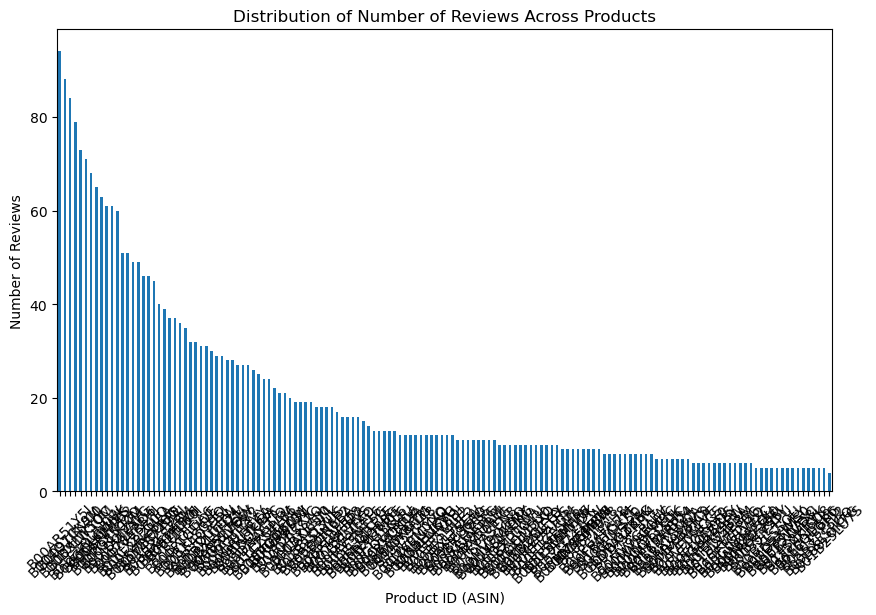

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the number of reviews per product (ASIN)
review_counts = df['asin'].value_counts()

# Create the plot
plt.figure(figsize=(10, 6))
review_counts.plot(kind='bar')
plt.title('Distribution of Number of Reviews Across Products')
plt.xlabel('Product ID (ASIN)')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.show()

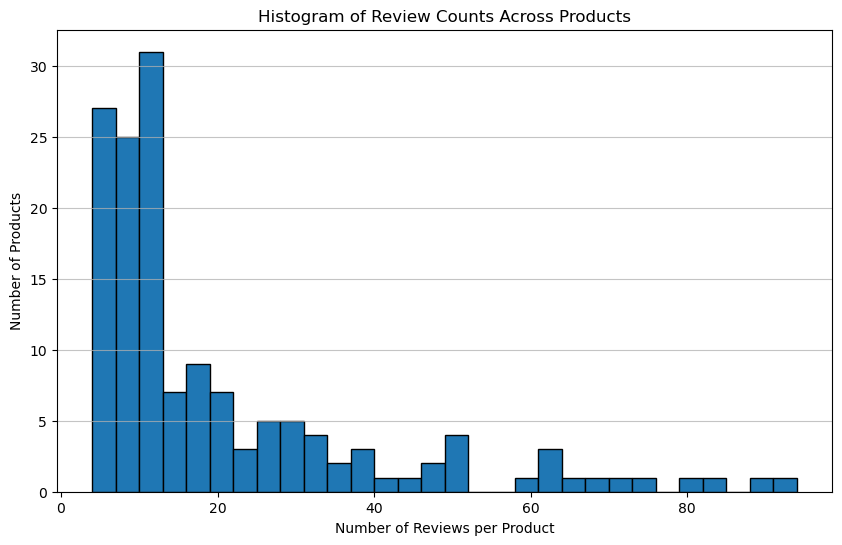

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the number of reviews per product (ASIN)
review_counts = df['asin'].value_counts()

# Create the histogram plot
plt.figure(figsize=(10, 6))
plt.hist(review_counts, bins=30, edgecolor='black')
plt.title('Histogram of Review Counts Across Products')
plt.xlabel('Number of Reviews per Product')
plt.ylabel('Number of Products')
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.show()


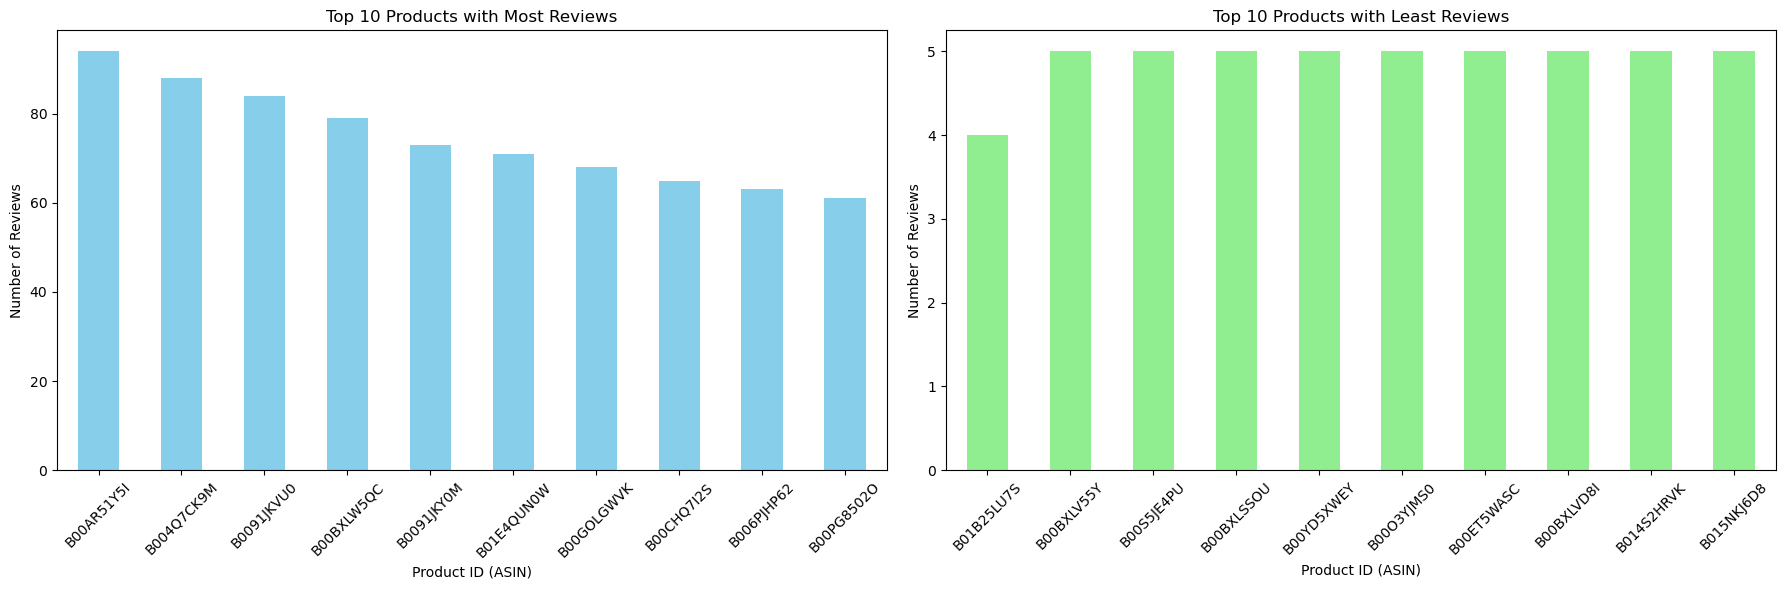

In [81]:
# Calculate the top 10 products with the most reviews
top_reviewed_asins = df['asin'].value_counts().head(10)

# Calculate the top 10 products with the least reviews
least_reviewed_asins = df['asin'].value_counts().nsmallest(10)

# Plotting both top and least reviewed products side by side for comparison
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Top reviewed ASINs plot
top_reviewed_asins.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Top 10 Products with Most Reviews')
axes[0].set_xlabel('Product ID (ASIN)')
axes[0].set_ylabel('Number of Reviews')
axes[0].tick_params(axis='x', rotation=45)

# Least reviewed ASINs plot
least_reviewed_asins.plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('Top 10 Products with Least Reviews')
axes[1].set_xlabel('Product ID (ASIN)')
axes[1].set_ylabel('Number of Reviews')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


/Users/josemuniz/opt/anaconda3/envs/PX39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


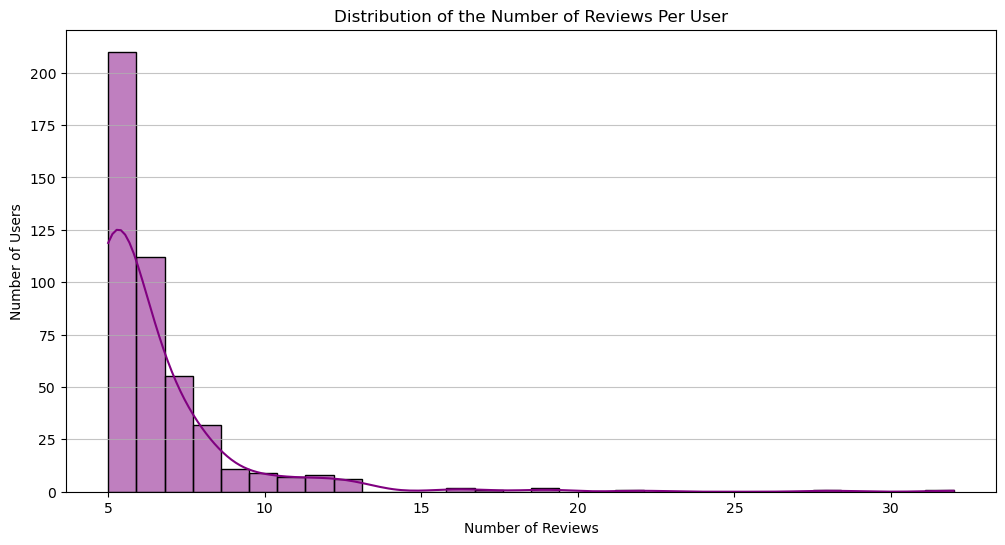

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the number of reviews per user
reviews_per_user = df['reviewerID'].value_counts()

# Plot the distribution of the number of reviews per user using seaborn
plt.figure(figsize=(12, 6))
sns.histplot(reviews_per_user, bins=30, kde=True, color='purple')
plt.title('Distribution of the Number of Reviews Per User')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Users')
plt.grid(axis='y', alpha=0.75)

plt.show()


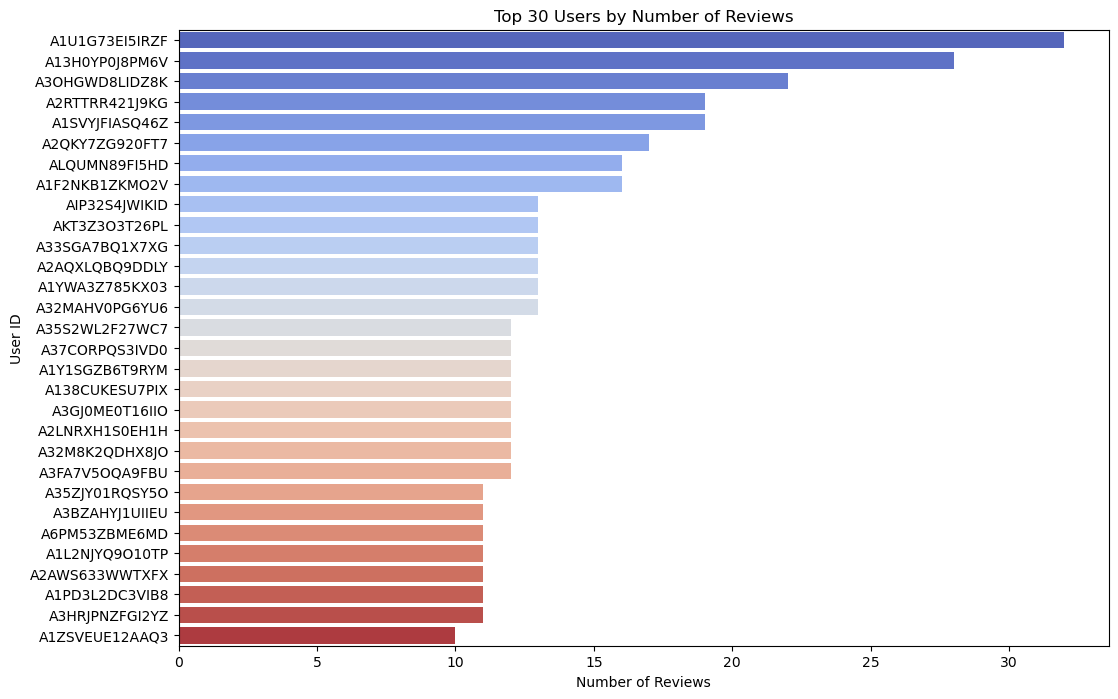

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it contains a column 'reviewerID'

# Calculate the top 30 users with the most reviews and their counts
top_30_users_reviews = df['reviewerID'].value_counts().head(30)

# Plotting the distribution of reviews for the top 30 users
plt.figure(figsize=(12, 8))
sns.barplot(y=top_30_users_reviews.index, x=top_30_users_reviews.values, palette='coolwarm')
plt.title('Top 30 Users by Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('User ID')

plt.show()
